In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [2]:
# remove the first row 
data = pd.read_csv('final_features_train.csv')
y_train = data['is_duplicate']
X_train = data.drop(['Unnamed: 0','is_duplicate'], axis=1)

In [3]:
X_train.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0.666644,0.666644,0.599988,0.599988,0.624992,0.624992,1.0,1.0,0.0,8.0,...,38.790349,6.417227,51.894864,-30.901261,-17.763131,36.825786,-37.379880,-24.054707,-38.778586,85.745141
1,0.749981,0.749981,0.000000,0.000000,0.374995,0.374995,1.0,0.0,0.0,8.0,...,6.358615,-83.278800,21.094343,40.515045,15.423308,55.957859,-21.368731,-10.521431,15.580367,42.280275
2,0.999950,0.499988,0.599988,0.599988,0.714276,0.499995,0.0,1.0,3.0,8.5,...,34.125774,-4.986566,19.527320,39.227552,16.493933,-1.061046,82.957511,29.372575,-10.130547,40.039223
3,0.499988,0.333328,0.499988,0.399992,0.499994,0.363633,1.0,0.0,3.0,9.5,...,74.209508,-9.563930,-9.990051,31.831249,-7.579658,-9.853520,-71.754162,-23.939064,-55.875440,16.681281
4,0.499988,0.499988,0.499988,0.499988,0.499994,0.444440,0.0,0.0,1.0,8.5,...,107.649658,-49.521651,87.932508,-22.009140,38.070376,13.961027,-61.009356,-50.378731,-48.824210,58.474072


In [4]:
data = pd.read_csv('final_features_test.csv')
y_test = data['is_duplicate']
X_test = data.drop(['Unnamed: 0','is_duplicate'], axis=1)

In [5]:
X_test.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0.000000,0.000000,0.749981,0.428565,0.333330,0.214284,0.0,1.0,5.0,11.5,...,102.534268,-59.795416,70.926186,67.985904,-12.332163,16.868944,44.916155,12.434165,-43.400853,33.900609
1,0.499988,0.399992,0.999975,0.499994,0.599994,0.399997,0.0,1.0,5.0,12.5,...,40.945590,-89.886899,32.529472,40.481994,-3.958799,25.575788,-99.096953,27.658936,-128.881564,73.138554
2,0.799984,0.799984,0.999980,0.833319,0.818174,0.692302,1.0,1.0,2.0,12.0,...,74.141469,-79.965424,62.512810,-3.172722,-25.707900,-47.923324,-60.171577,26.780698,-74.153949,160.745279
3,0.833319,0.833319,0.999975,0.999975,0.899991,0.899991,0.0,1.0,0.0,10.0,...,99.159081,23.916904,19.232367,54.147183,48.728419,-14.590290,-27.794064,49.409487,-47.196071,10.507677
4,0.666656,0.444440,0.999950,0.666644,0.749991,0.499996,0.0,1.0,4.0,10.0,...,82.222882,-42.391510,99.963269,-9.165464,28.807939,28.815999,-110.290182,-21.324194,-62.193401,135.953693


<h2> 4.2 Converting strings to numerics </h2>

In [6]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(X_train.columns)
for i in cols:
    X_train[i] = X_train[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y

In [7]:
cols = list(X_test.columns)
for i in cols:
    X_test[i] = X_test[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y

In [8]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_train = list(map(int, y_train.values))

In [10]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 218)
Number of data points in test data : (30000, 218)


In [11]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6273714285714286 Class 1:  0.3726285714285714
---------- Distribution of output variable in train data ----------
Class 0:  0.37233333333333335 Class 1:  0.37233333333333335


In [12]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8931926833490992


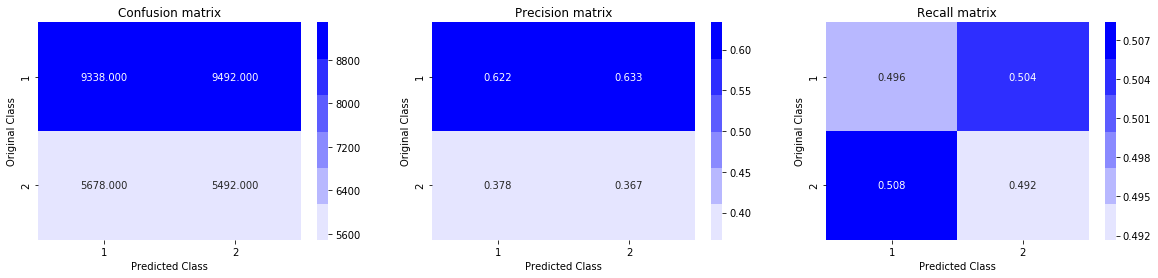

In [13]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.5241621223767803
For values of alpha =  0.0001 The log loss is: 0.5249217043515392
For values of alpha =  0.001 The log loss is: 0.5223536023912372
For values of alpha =  0.01 The log loss is: 0.5307880005486226
For values of alpha =  0.1 The log loss is: 0.5309917781841222
For values of alpha =  1 The log loss is: 0.5182110653677025
For values of alpha =  10 The log loss is: 0.531740152684863


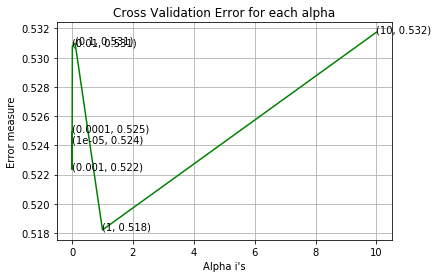

For values of best alpha =  1 The train log loss is: 0.5137445807710874
For values of best alpha =  1 The test log loss is: 0.5182110653677025
Total number of data points : 30000


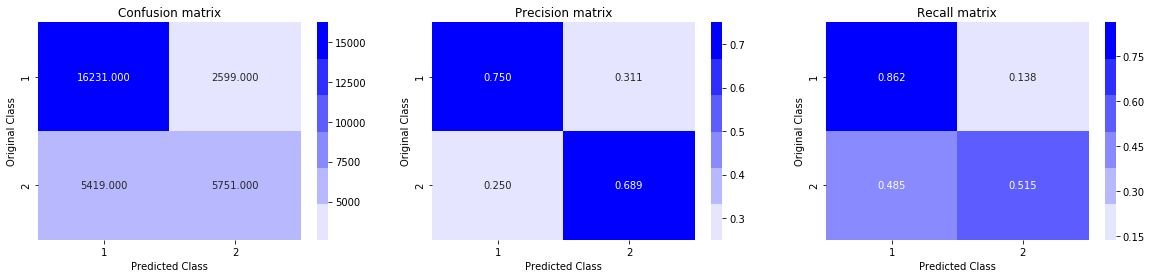

In [14]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6601860521334062
For values of alpha =  0.0001 The log loss is: 0.48052147166540876
For values of alpha =  0.001 The log loss is: 0.4937483996205837
For values of alpha =  0.01 The log loss is: 0.5433156128269077
For values of alpha =  0.1 The log loss is: 0.6051079405340032
For values of alpha =  1 The log loss is: 0.633471063490082
For values of alpha =  10 The log loss is: 0.646074456069417


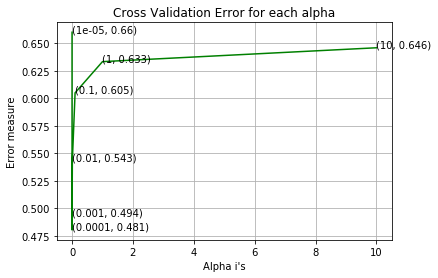

For values of best alpha =  0.0001 The train log loss is: 0.4788782336016063
For values of best alpha =  0.0001 The test log loss is: 0.48052147166540876
Total number of data points : 30000


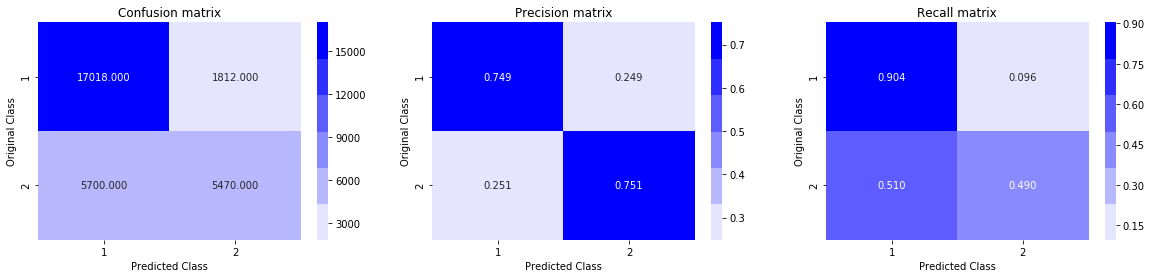

In [15]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [17]:
import xgboost as xgb
eta = np.arange(0,0.1,0.01)
lostval = []
for i in range(4,8): 
    p = []
    for j in eta: 
        params = {}
        params['objective'] = 'binary:logistic'
        params['eval_metric'] = 'logloss'
        params['eta'] = j
        params['max_depth'] = i

        d_train = xgb.DMatrix(X_train, label=y_train)
        d_test = xgb.DMatrix(X_test, label=y_test)

        watchlist = [(d_train, 'train'), (d_test, 'valid')]

        bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

        xgdmat = xgb.DMatrix(X_train,y_train)
        predict_y = bst.predict(d_test)
        p.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
        print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    lostval.append(p)

[0]	train-logloss:0.693202	valid-logloss:0.693133
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.693202	valid-logloss:0.693133
[20]	train-logloss:0.693202	valid-logloss:0.693133
Stopping. Best iteration:
[0]	train-logloss:0.693202	valid-logloss:0.693133

The test log loss is: 0.6931471824645996
[0]	train-logloss:0.688979	valid-logloss:0.688989
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.651602	valid-logloss:0.651478
[20]	train-logloss:0.619875	valid-logloss:0.619657
[30]	train-logloss:0.592248	valid-logloss:0.591915
[40]	train-logloss:0.568463	valid-logloss:0.568067
[50]	train-logloss:0.547929	valid-logloss:0.54754
[60]	train-logloss:0.530038	valid-logloss:0.529656
[70]	train-logloss:0.514299	valid-logloss:0.513993
[80]	train-logloss:0.5

[140]	train-logloss:0.361707	valid-logloss:0.367029
[150]	train-logloss:0.359608	valid-logloss:0.365483
[160]	train-logloss:0.357152	valid-logloss:0.363596
[170]	train-logloss:0.354891	valid-logloss:0.361912
[180]	train-logloss:0.352734	valid-logloss:0.360371
[190]	train-logloss:0.350733	valid-logloss:0.35892
[200]	train-logloss:0.348859	valid-logloss:0.357584
[210]	train-logloss:0.347175	valid-logloss:0.356378
[220]	train-logloss:0.345617	valid-logloss:0.355427
[230]	train-logloss:0.344092	valid-logloss:0.354404
[240]	train-logloss:0.342675	valid-logloss:0.353569
[250]	train-logloss:0.341275	valid-logloss:0.352756
[260]	train-logloss:0.340109	valid-logloss:0.352021
[270]	train-logloss:0.338739	valid-logloss:0.351228
[280]	train-logloss:0.337428	valid-logloss:0.350557
[290]	train-logloss:0.3361	valid-logloss:0.349839
[300]	train-logloss:0.334908	valid-logloss:0.349251
[310]	train-logloss:0.333782	valid-logloss:0.348737
[320]	train-logloss:0.332635	valid-logloss:0.348261
[330]	train-log

[390]	train-logloss:0.302715	valid-logloss:0.340279
[399]	train-logloss:0.301572	valid-logloss:0.34002
The test log loss is: 0.3400196915203504
[0]	train-logloss:0.66109	valid-logloss:0.660993
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.489374	valid-logloss:0.489016
[20]	train-logloss:0.426851	valid-logloss:0.426938
[30]	train-logloss:0.397896	valid-logloss:0.399006
[40]	train-logloss:0.382722	valid-logloss:0.384918
[50]	train-logloss:0.373881	valid-logloss:0.377133
[60]	train-logloss:0.366745	valid-logloss:0.371094
[70]	train-logloss:0.361316	valid-logloss:0.366854
[80]	train-logloss:0.357145	valid-logloss:0.363863
[90]	train-logloss:0.352465	valid-logloss:0.360425
[100]	train-logloss:0.34901	valid-logloss:0.358011
[110]	train-logloss:0.345728	valid-logloss:0.355952
[120]	train-logloss:0.342435	valid-logloss:0.353871
[130]	train-logloss:0.339267	valid-logloss

[120]	train-logloss:0.385713	valid-logloss:0.389607
[130]	train-logloss:0.380825	valid-logloss:0.3851
[140]	train-logloss:0.376563	valid-logloss:0.381262
[150]	train-logloss:0.373053	valid-logloss:0.378121
[160]	train-logloss:0.36981	valid-logloss:0.375275
[170]	train-logloss:0.36687	valid-logloss:0.372747
[180]	train-logloss:0.364437	valid-logloss:0.37071
[190]	train-logloss:0.362105	valid-logloss:0.368809
[200]	train-logloss:0.360009	valid-logloss:0.367129
[210]	train-logloss:0.358129	valid-logloss:0.365597
[220]	train-logloss:0.356387	valid-logloss:0.364212
[230]	train-logloss:0.354705	valid-logloss:0.362913
[240]	train-logloss:0.353016	valid-logloss:0.361645
[250]	train-logloss:0.351406	valid-logloss:0.360496
[260]	train-logloss:0.349905	valid-logloss:0.359426
[270]	train-logloss:0.348419	valid-logloss:0.358448
[280]	train-logloss:0.346883	valid-logloss:0.357457
[290]	train-logloss:0.345607	valid-logloss:0.356703
[300]	train-logloss:0.344155	valid-logloss:0.355812
[310]	train-loglo

[370]	train-logloss:0.292098	valid-logloss:0.337799
[380]	train-logloss:0.290834	valid-logloss:0.337561
[390]	train-logloss:0.289541	valid-logloss:0.337343
[399]	train-logloss:0.287963	valid-logloss:0.337133
The test log loss is: 0.3371325849615668
[0]	train-logloss:0.66725	valid-logloss:0.667299
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.511162	valid-logloss:0.511786
[20]	train-logloss:0.440005	valid-logloss:0.441485
[30]	train-logloss:0.404415	valid-logloss:0.407014
[40]	train-logloss:0.384289	valid-logloss:0.38829
[50]	train-logloss:0.371834	valid-logloss:0.377026
[60]	train-logloss:0.363826	valid-logloss:0.370351
[70]	train-logloss:0.357654	valid-logloss:0.365412
[80]	train-logloss:0.352515	valid-logloss:0.361393
[90]	train-logloss:0.347797	valid-logloss:0.358149
[100]	train-logloss:0.343359	valid-logloss:0.355296
[110]	train-logloss:0.339382	valid-loglos

[180]	train-logloss:0.299438	valid-logloss:0.339421
[190]	train-logloss:0.29638	valid-logloss:0.339089
[200]	train-logloss:0.293554	valid-logloss:0.338598
[210]	train-logloss:0.291122	valid-logloss:0.338341
[220]	train-logloss:0.288269	valid-logloss:0.337899
[230]	train-logloss:0.286107	valid-logloss:0.33782
[240]	train-logloss:0.283376	valid-logloss:0.337455
[250]	train-logloss:0.280701	valid-logloss:0.337326
[260]	train-logloss:0.278155	valid-logloss:0.337255
[270]	train-logloss:0.275385	valid-logloss:0.337095
[280]	train-logloss:0.272766	valid-logloss:0.336786
[290]	train-logloss:0.270252	valid-logloss:0.33672
[300]	train-logloss:0.267664	valid-logloss:0.336471
[310]	train-logloss:0.265755	valid-logloss:0.33636
[320]	train-logloss:0.262974	valid-logloss:0.336183
[330]	train-logloss:0.261164	valid-logloss:0.336087
[340]	train-logloss:0.259517	valid-logloss:0.335985
[350]	train-logloss:0.257211	valid-logloss:0.335898
[360]	train-logloss:0.254585	valid-logloss:0.335674
[370]	train-logl

[350]	train-logloss:0.298284	valid-logloss:0.339784
[360]	train-logloss:0.296448	valid-logloss:0.339439
[370]	train-logloss:0.294849	valid-logloss:0.339066
[380]	train-logloss:0.293149	valid-logloss:0.338736
[390]	train-logloss:0.291368	valid-logloss:0.338366
[399]	train-logloss:0.289829	valid-logloss:0.338156
The test log loss is: 0.3381557369432863
[0]	train-logloss:0.674757	valid-logloss:0.674923
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.547325	valid-logloss:0.549082
[20]	train-logloss:0.476312	valid-logloss:0.479355
[30]	train-logloss:0.433485	valid-logloss:0.438124
[40]	train-logloss:0.405469	valid-logloss:0.411565
[50]	train-logloss:0.386209	valid-logloss:0.393787
[60]	train-logloss:0.373379	valid-logloss:0.382513
[70]	train-logloss:0.363663	valid-logloss:0.374379
[80]	train-logloss:0.356754	valid-logloss:0.368646
[90]	train-logloss:0.350726	valid-logl

[160]	train-logloss:0.293322	valid-logloss:0.339421
[170]	train-logloss:0.289987	valid-logloss:0.339126
[180]	train-logloss:0.286378	valid-logloss:0.338617
[190]	train-logloss:0.282973	valid-logloss:0.338237
[200]	train-logloss:0.27898	valid-logloss:0.337734
[210]	train-logloss:0.275896	valid-logloss:0.337507
[220]	train-logloss:0.273085	valid-logloss:0.337092
[230]	train-logloss:0.269296	valid-logloss:0.336639
[240]	train-logloss:0.266668	valid-logloss:0.33642
[250]	train-logloss:0.263404	valid-logloss:0.336116
[260]	train-logloss:0.259461	valid-logloss:0.335609
[270]	train-logloss:0.25631	valid-logloss:0.335218
[280]	train-logloss:0.253815	valid-logloss:0.335062
[290]	train-logloss:0.250951	valid-logloss:0.334865
[300]	train-logloss:0.247769	valid-logloss:0.33469
[310]	train-logloss:0.245417	valid-logloss:0.334542
[320]	train-logloss:0.242377	valid-logloss:0.334482
[330]	train-logloss:0.239137	valid-logloss:0.334243
[340]	train-logloss:0.236473	valid-logloss:0.333943
[350]	train-logl

[330]	train-logloss:0.338441	valid-logloss:0.360863
[340]	train-logloss:0.336888	valid-logloss:0.359679
[350]	train-logloss:0.335375	valid-logloss:0.358608
[360]	train-logloss:0.333989	valid-logloss:0.357643
[370]	train-logloss:0.332588	valid-logloss:0.356713
[380]	train-logloss:0.331253	valid-logloss:0.355794
[390]	train-logloss:0.329918	valid-logloss:0.354974
[399]	train-logloss:0.32867	valid-logloss:0.354185
The test log loss is: 0.3541845240470022
[0]	train-logloss:0.683345	valid-logloss:0.683536
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.603277	valid-logloss:0.605259
[20]	train-logloss:0.545363	valid-logloss:0.549206
[30]	train-logloss:0.502308	valid-logloss:0.507776
[40]	train-logloss:0.469183	valid-logloss:0.475958
[50]	train-logloss:0.443183	valid-logloss:0.451516
[60]	train-logloss:0.42242	valid-logloss:0.432241
[70]	train-logloss:0.405879	valid-logl

[140]	train-logloss:0.298162	valid-logloss:0.342251
[150]	train-logloss:0.293356	valid-logloss:0.341279
[160]	train-logloss:0.288311	valid-logloss:0.340325
[170]	train-logloss:0.284171	valid-logloss:0.33934
[180]	train-logloss:0.279858	valid-logloss:0.338671
[190]	train-logloss:0.277016	valid-logloss:0.33816
[200]	train-logloss:0.273235	valid-logloss:0.33747
[210]	train-logloss:0.26915	valid-logloss:0.336927
[220]	train-logloss:0.265844	valid-logloss:0.336626
[230]	train-logloss:0.263004	valid-logloss:0.336337
[240]	train-logloss:0.259536	valid-logloss:0.335974
[250]	train-logloss:0.256419	valid-logloss:0.335665
[260]	train-logloss:0.253049	valid-logloss:0.335335
[270]	train-logloss:0.249859	valid-logloss:0.334881
[280]	train-logloss:0.247477	valid-logloss:0.334686
[290]	train-logloss:0.244045	valid-logloss:0.334332
[300]	train-logloss:0.240731	valid-logloss:0.334055
[310]	train-logloss:0.236371	valid-logloss:0.333642
[320]	train-logloss:0.233514	valid-logloss:0.333618
[330]	train-logl

[390]	train-logloss:0.153154	valid-logloss:0.331942
Stopping. Best iteration:
[377]	train-logloss:0.157048	valid-logloss:0.331727

The test log loss is: 0.33215931625136746
[0]	train-logloss:0.650553	valid-logloss:0.651456
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.444614	valid-logloss:0.452432
[20]	train-logloss:0.376041	valid-logloss:0.391076
[30]	train-logloss:0.347791	valid-logloss:0.368149
[40]	train-logloss:0.331796	valid-logloss:0.356746
[50]	train-logloss:0.320537	valid-logloss:0.350327
[60]	train-logloss:0.312047	valid-logloss:0.346803
[70]	train-logloss:0.304441	valid-logloss:0.344457
[80]	train-logloss:0.295213	valid-logloss:0.342198
[90]	train-logloss:0.286979	valid-logloss:0.340672
[100]	train-logloss:0.279032	valid-logloss:0.339486
[110]	train-logloss:0.270046	valid-logloss:0.3382
[120]	train-logloss:0.264671	valid-logloss:0.337886
[130]	train-l

In [18]:
dtdepth = [x for x in range(4,8)]
log_range = pd.DataFrame(lostval, index = dtdepth, columns = eta)

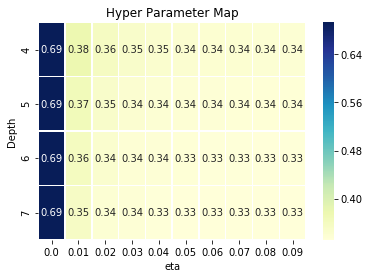

In [20]:
sns.heatmap(log_range, annot = True, cmap="YlGnBu" , linewidths=.5) 
plt.title("Hyper Parameter Map")
plt.xlabel("eta")
plt.ylabel("Depth")
plt.show()

In [21]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.05
params['max_depth'] = 6
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)
watchlist = [(d_train, 'train'), (d_test, 'valid')]
bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)
xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.67027	valid-logloss:0.670491
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.523332	valid-logloss:0.525447
[20]	train-logloss:0.450848	valid-logloss:0.454742
[30]	train-logloss:0.410338	valid-logloss:0.416287
[40]	train-logloss:0.385913	valid-logloss:0.393691
[50]	train-logloss:0.370599	valid-logloss:0.380399
[60]	train-logloss:0.359839	valid-logloss:0.371184
[70]	train-logloss:0.35202	valid-logloss:0.36498
[80]	train-logloss:0.34593	valid-logloss:0.360547
[90]	train-logloss:0.340618	valid-logloss:0.356959
[100]	train-logloss:0.336442	valid-logloss:0.354445
[110]	train-logloss:0.332363	valid-logloss:0.352004
[120]	train-logloss:0.328111	valid-logloss:0.349943
[130]	train-logloss:0.324185	valid-logloss:0.34804
[140]	train-logloss:0.320576	valid-logloss:0.346633
[150]	train-logloss:0.316861	valid-logloss:0.345234
[160]	train-logloss:0.313189	vali

Total number of data points : 30000


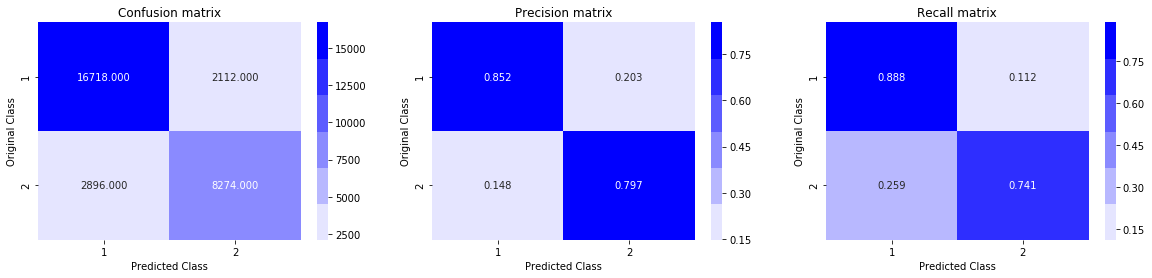

In [22]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h1> 5. Assignments </h1>

1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.


In [1]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer","Model","Hyper Parameter (alpha)","log loss"]
x.add_row(["Weighted TFIDF", "Logistic Regression", 1, 0.51])
x.add_row(["Weighted TFIDF", "Linear SVM", 0.0001, 0.48])

print(x)

+----------------+---------------------+-------------------------+----------+
|   Vectorizer   |        Model        | Hyper Parameter (alpha) | log loss |
+----------------+---------------------+-------------------------+----------+
| Weighted TFIDF | Logistic Regression |            1            |   0.51   |
| Weighted TFIDF |      Linear SVM     |          0.0001         |   0.48   |
+----------------+---------------------+-------------------------+----------+


In [2]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer","Model","Hyper Parameter (eta)","Hyper Parameter (depth)" ,"log loss"]
x.add_row(["Weighted TFIDF", "XGBoost", 0.05, 6,0.334])
print(x)


+----------------+---------+-----------------------+-------------------------+----------+
|   Vectorizer   |  Model  | Hyper Parameter (eta) | Hyper Parameter (depth) | log loss |
+----------------+---------+-----------------------+-------------------------+----------+
| Weighted TFIDF | XGBoost |          0.05         |            6            |  0.334   |
+----------------+---------+-----------------------+-------------------------+----------+


#### Step followed to solve case study

 - ____Step 1____ : Analyze data and determine features that can be built using the dataset.
 - ____Step 2____ : Perform EDA on features to see if they add value to the model to be built.
 - ____Step 3____ : Preprocess the data to remove Null or NaN values. Also convert data into features and stack them horizontally. 
 - ____Step 4____ : Split data into Test and train data.
 - ____Step 5____ : Use tfidfvectorizer to convert text data into numerical values. Use GLOVE to convert tfidfvectorizer data into weighted TFIDF. Also use features of tfidfvectorizer to form another dataset of simple tfidf.
 - ____Step 6____ : Apply Logistic Regress ('Log loss') and Linear SVM ('Hinge Loss') on the vectorized data sample. Also apply XGBoost on the data sample.
 - ____Step 7____ : Find the corresponding log-loss in each case.
 - ____Step 8____ : The best model is determined with one having the least log-loss.